In [1]:
# Standard python imports
import os
import h5py
import numpy as np
import pandas as pd
import json
from tqdm import tqdm, tnrange, tqdm_notebook

# Keras, tf, and sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
# Try seeing if we are using a gpu?
from keras import backend as K
from keras.models import model_from_json
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.set_session(sess)
print("Using gpu: ", K.tensorflow_backend._get_available_gpus())

# Make reproducible
SEED = 32
np.random.seed(SEED)
tf.set_random_seed(SEED)

# My module imports
import utils
from make_models import model_1d

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Using gpu:  ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Maybe get the data .mat file
if not os.path.isfile("data.mat"):
    !wget https://www.dropbox.com/s/b1bnrj2f30xe1ns/xq_data_big.mat?dl=0
    !mv 'xq_data_big.mat?dl=0' data.mat

# Import the data from file
f = h5py.File("data.mat")
data_0, labels_0 = np.array(f['data']), np.array(f['labels'])
data, labels = data_0.copy(), labels_0.copy()
f.close()

# Correlations

In [33]:
colInds = pd.read_csv("assets/divergences.csv")["Gene_index"].values[:1000]
data = data_0[:, colInds].T
corr = np.corrcoef(data)

In [34]:
np.save("assets/corr.npy", corr)
corr = np.load("assets/corr.npy")

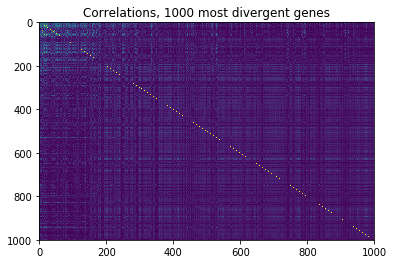

In [36]:
f = lambda x: np.abs(x)
plt.imshow(f(corr), aspect='auto')
plt.title(f"Correlations, {corr.shape[0]} most divergent genes");

# Show Mutual Info and JS divergence are the same

In [3]:
# Labels are off by 1 cuz matlab
labels = labels.squeeze().astype(int) - 1

In [12]:
# Get mutual_info csv
colInds = np.where(np.sum(data_0, axis=0) != 0.0)[0]
data = data_0[:, colInds].astype(int)
mi_scores = np.array([mutual_info_score(data[:, i], labels) for i in tnrange(data.shape[1])])
js_scores = np.array([utils.gene_divergence(data[:, i], labels) for i in tnrange(data.shape[1])])
assert(np.all(np.isclose(mi_scores, js_scores)))

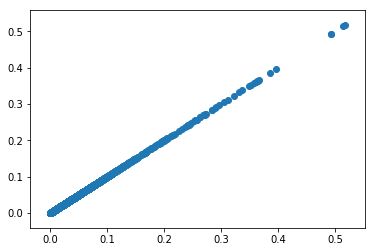

In [5]:
plt.scatter(mi_scores, js_scores)

# Getting Divergences CSV

# Finding Minimal Gene Set

In [ ]:
# Labels are off by 1 cuz matlab, also one-hot the labels
labels = (np.arange(10) == (labels_0 - 1)).astype(np.float32)
colInds = np.where(np.sum(data_0, axis=0) != 0.0)[0]
data = utils.preprocess(data_0, colInds)
# Get test and training
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Reshape the data
test_data = test_data[:, :, None, None]
train_data = train_data[:, :, None, None]

# Save a model to pull up later
model = model_1d(data.shape[0], conv_channels=[16, 16, 32, 64, 128], dense_neurons=[512], n_class=10, \
                         conv_ks=[20, 10, 10, 2, 5], \
                         pool_ks=[2, 4, 4, 4, 3], \
                         pads=['same', 'same', 'same', 'valid', 'same'], \
                         pool_type='max',\
                         dropout_strength=0.5)
model_s = model.to_json()

In [ ]:
def getTestAccuracy(train_data, test_data, train_labels, test_labels, \
                    epochs=5, BATCH_SIZE=60, NCLASS=10, model_s=None):
    # Make and fit a model
    K.clear_session()
    if model_s is not None:
        model=model_from_json(model_s)
        model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    else:
        model = model_1d(data.shape[1], conv_channels=[16, 16, 32, 64, 128], dense_neurons=[512], n_class=NCLASS, \
                         conv_ks=[20, 10, 10, 2, 5], \
                         pool_ks=[2, 4, 4, 4, 3], \
                         pads=['same', 'same', 'same', 'valid', 'same'], \
                         pool_type='max',\
                         dropout_strength=0.5)
        
    model.fit(train_data, train_labels, 
          batch_size=BATCH_SIZE, epochs=epochs,\
          verbose=1)
    
    return model.evaluate(test_data, test_labels, verbose=0)[1]

In [ ]:
starts = np.arange(0, 1000, 100)
stops = starts + 100
accuracies = np.empty(starts.shape[0])
indices_in_orig = pd.read_csv("assets/divergences.csv")["Gene_index"].values # Values in original data_matrix
indices = [list(colInds).index(ind) for ind in indices_in_orig] # Values in data_matrix with no zero_columns

for i, (s, e) in enumerate(zip(starts, stops)):
    print(f"Evaluating data-set {i + 1}/{len(starts)}")
    print(f"Start: {s}, Stop: {e}")
    zero_cols = indices[s:e]
    lost_data = (train_data[:, zero_cols], test_data[:, zero_cols])# Comment_out to not Don't bother restoring data
    train_data[:, zero_cols] = 0
    test_data[:, zero_cols] = 0
    accuracies[i] = getTestAccuracy(train_data, test_data, train_labels, test_labels, model_s=model_s, epochs=5)
    (train_data[:, zero_cols], test_data[:, zero_cols]) = lost_data
    print(f"Accuracy: {accuracies[i]}")
    print("\n")

In [ ]:
import pickle
with open("accuracies.pkl", "wb") as f:
    pickle.dump((starts, stops, accuracies), f)

In [ ]:
with open("accuracies.pkl", "rb") as f:
    starts, stops, accs = pickle.load(f)

plt.plot(starts, accs)